Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Yifei"
COLLABORATORS = ""

---

In [2]:
from __future__ import print_function
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time

# HW 7:  ODE Methods for Stiff problems and Intro to Linear Algebra



## Question 1: Solver comparison for stiff solvers

The classic example of a stiff non-linear ODE is the Van der Pol oscillator

$$x^{\prime\prime} - \mu (1 - x^2) x^\prime + x = 0 \quad \quad \text{with} \quad \quad  x(0) = x_0, \quad x^\prime(0) = v_0$$

Which admits a single periodic limit cycle for any given value of $\mu$ and initial condition.

This problem is extremely stiff for large values of $\mu$ and will break most explicit ODE solvers due to stability issues.  

In addition,  this problem  also puts a strain on any **fixed time-step** integrator as there are large periods of slow growth punctuated by very rapid changes in time.  Thus maintaining accuracy for a non-adaptive code remains challenging.

This problem set will explore some of these numerical issues through a variety of sub-problems and emphasize the importance of stability, accuracy and adaptability.

**(a) Derivation and coding** [6 pts]: introduce the auxiliary variable $v=x^\prime$ and rewrite the problem as a 2-dimensional non-linear autonomous dynamical system 

$$\mathbf{u}^\prime = \mathbf{f}(\mathbf{u;\mu})$$

where
$$
    \mathbf{u} = \begin{bmatrix} x \\ v \\\end{bmatrix}, \quad \mathbf{f} = \begin{bmatrix} f_1(x,v) \\ f_2(x,v) \\\end{bmatrix}
$$

$f_1(x,v)=v$

$f_2(x,v)=\mu(1-x^2)v-x$

now write a short python function to return the righthand side $\mathbf{f}(t,\mathbf{u};\mu)$.  

While we are at it, write a routine to return  the jacobian of $\mathbf{f}$,  $\mathcal{J}(t,\mathbf{u};\mu)$ whose components are defined as

$$
    \mathcal{J}_{i,j} = \frac{\partial f_i}{\partial u_j}
$$

(you would need this if you were going to use Newtons method to solve a BDF scheme)

In [3]:
#  Add code to evaluate the RHS of the vanderpol equation
def fvanderpol(t,u,mu):
    """ RHS of vanderpol equation (you can improve this docstring)            
    """
    return [u[1],mu*(1-u[0]**2)*u[1]-u[0]]
    
# the jacobian of the right hand side
def jvanderpol(t, u, mu):
    """ Jacobian of RHS of vanderpol equation"""
    return [[0,1],[mu*u[1]*(-2*u[0])-1,mu*(1-u[0]**2)]]

In [4]:
t=0. 
u = numpy.array([1.5, 2.])
mu = 0.
# test f
answer = numpy.array([2., -1.5])
numpy.testing.assert_allclose(answer,fvanderpol(t, u, mu))
# test jacobian
answer = numpy.array([[0., 1.], [-1., 0]])
numpy.testing.assert_allclose(answer,jvanderpol(t, u, mu))


mu = 10.
#  test f
answer = numpy.array([  2. , -26.5])
numpy.testing.assert_allclose(answer,fvanderpol(t, u, mu))
answer = numpy.array([[  0.,    1. ], [-61.,  -12.5]])
numpy.testing.assert_allclose(answer,jvanderpol(t, u, mu))
print('success')

success


Now Explore solving this problem using `scipy.integrate.solve_ivp` for  a range of $\mu$ and different methods

For this problem we will integrate the vanderpol equations starting at initial condition $\mathbf{u}_0=[1.,0]$ for the time interval $t\in[0,100]$ and compare the behavior of four different methods 

* Embedded RK method RK45
* BDF
* Radau 
* any other method supported by solve_ivp

for 11 values of the damping parameter $\mu$ in the range $[1,100]$

**(b)** [6 pts] 

Make three plots that compare  your 4 methods as a function of $\mu$ in terms of

1. the number of *time steps* required to solve this problem 
2. the number of *function evaluations* required (see below) 
3. the elapsed run time for each method in seconds (see below)

**Some hints:**
* Most of the pieces of this are in the notebook. 
* a log scale for the y axis might be useful
* use a lambda function to handle the extra argument $\mu$.  I can't seem to get `solve_ivp` to work in a sensible way with the args argument (unless you do something wierd like `args=([mu])` but let me know if you find a clean fix)
* Look at the documentation for solve_ivp to figure out how to get the number of function valuations
* To calculate the run time in python 3 you can use something like

```python
import time
tic = time.perf_counter()
<do something>
toc = time.perf_counter()
elapsed_time = toc -tic
```

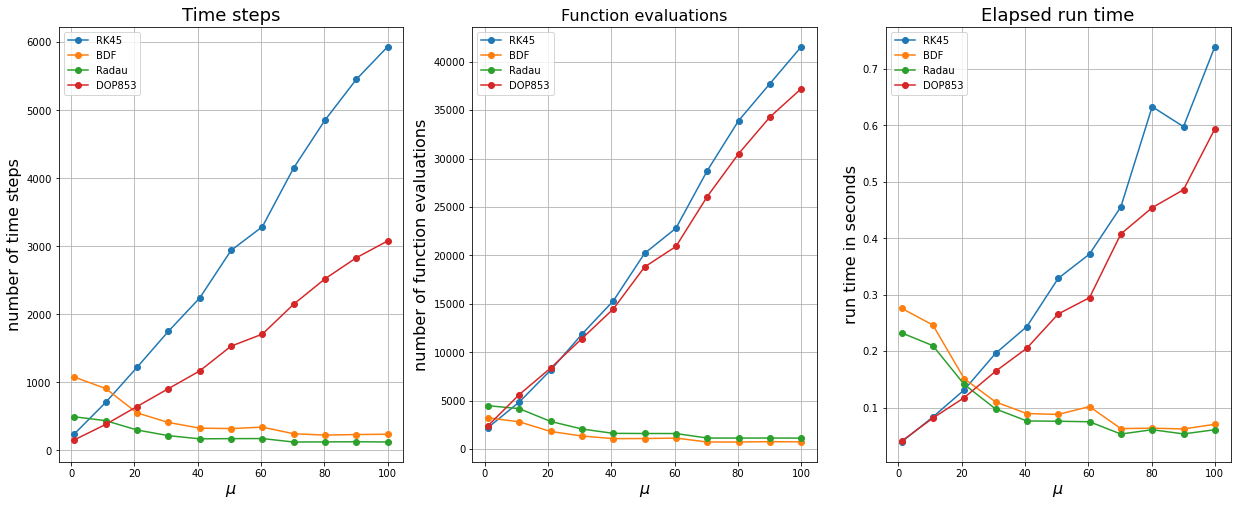

In [5]:
import time

t_span = (0., 100.)
u0 = [ 1., 0. ]
MU=numpy.linspace(1,100,11)
step_RK45=[]
fe_RK45=[]
t_RK45=[]

step_BDF=[]
fe_BDF=[]
t_BDF=[]

step_Radau=[]
fe_Radau=[]
t_Radau=[]

step_DOP853=[]
fe_DOP853=[]
t_DOP853=[]

for mu in MU:
    f = lambda t, u: fvanderpol(t, u, mu=mu)
    #RK45
    tic=time.perf_counter()
    sol=solve_ivp(f, t_span, u0, method='RK45')
    toc=time.perf_counter()
    t_RK45.append(toc-tic)
    step_RK45.append(len(sol.t))
    fe_RK45.append(sol.nfev)
    #BDF
    tic=time.perf_counter()
    sol=solve_ivp(f, t_span, u0, method='BDF')
    toc=time.perf_counter()
    t_BDF.append(toc-tic)
    step_BDF.append(len(sol.t))
    fe_BDF.append(sol.nfev)
    #Radau
    tic=time.perf_counter()
    sol=solve_ivp(f, t_span, u0, method='Radau')
    toc=time.perf_counter()
    t_Radau.append(toc-tic)
    step_Radau.append(len(sol.t))
    fe_Radau.append(sol.nfev)
    #DOP853
    tic=time.perf_counter()
    sol=solve_ivp(f, t_span, u0, method='DOP853')
    toc=time.perf_counter()
    t_DOP853.append(toc-tic)
    step_DOP853.append(len(sol.t))
    fe_DOP853.append(sol.nfev)
    
fig = plt.figure(figsize=(21,8))
axes = fig.add_subplot(1, 3, 1)

axes.plot(MU, step_RK45,'o-',label='RK45')
axes.plot(MU, step_BDF,'o-',label='BDF')
axes.plot(MU, step_Radau,'o-',label='Radau')
axes.plot(MU, step_DOP853,'o-',label='DOP853')
axes.set_title("Time steps", fontsize=18)
axes.set_xlabel("$\mu$", fontsize=16)
axes.set_ylabel("number of time steps", fontsize=16)
axes.legend(loc='best')
axes.grid()

axes = fig.add_subplot(1, 3, 2)
axes.plot(MU, fe_RK45,'o-',label='RK45')
axes.plot(MU, fe_BDF,'o-',label='BDF')
axes.plot(MU, fe_Radau,'o-',label='Radau')
axes.plot(MU, fe_DOP853,'o-',label='DOP853')
axes.grid()
axes.set_xlabel('$\mu$', fontsize=16)
axes.set_ylabel('number of function evaluations', fontsize=16)
axes.legend(loc='best')
axes.set_title('Function evaluations', fontsize=16)

axes = fig.add_subplot(1, 3, 3)
axes.plot(MU, t_RK45,'o-',label='RK45')
axes.plot(MU, t_BDF,'o-',label='BDF')
axes.plot(MU, t_Radau,'o-',label='Radau')
axes.plot(MU, t_DOP853,'o-',label='DOP853')
axes.set_title("Elapsed run time", fontsize=18)
axes.set_xlabel("$\mu$", fontsize=16)
axes.set_ylabel("run time in seconds", fontsize=16)
axes.legend(loc='best')
axes.grid()

plt.show()
    


**(c)** [4 pts] Comment on your results here (**Hint** it might be useful to actually plot the behavior of the solution (or look at the notes) to understand your graphs)

When $\mu$ is very small, that is less oscillating, explicit methods (RK45 and DOP853) out performanced implicit methods (BDF and Radau). However, as $\mu$ gets greater, implicit methods have much better performance than explicit methods since the problem oscillating more and thus become even more stiff.

### Project suggestion  Roll your own BDF-2 scheme using Newton's method

A more challenging problem is to write your own  BDF-2 scheme that uses Newton's method to solve the non-linear system of equations that arises at each time step.  Some things you should consider

1. Implement and test a routine for Newton's method
2. Implement a *fixed* time step BDF-2 scheme and test it against `solve_ivp` for the vanderpol oscillator. Some Hints:
    * you will need that jacobian here
    * you will need a way to get started (e.g. a BDF-1 scheme for the first step)
    * you will need to be able to handle exceptions from the Newton solver
3. For vanderpol, at least, you will find that to be efficient you will need both L-stability and adaptivity.  Consider how to use interpolation to make an adaptive BDF-23 scheme that compares the solution from a BDF-2 step with a BDF-3 step to control the time step (this is challenging).  Again, test your scheme against `solve_ivp`


# Linear Algebra: Part 1

## Question 2: Matrix Norms and Condition Numbers

Consider the Matrices

$$
    A = \begin{bmatrix} 1 & 1 \\
                        1 & a \\
         \end{bmatrix} \quad\quad
     A^{-1} = \frac{1}{a-1}\begin{bmatrix} a & -1 \\
                        -1 & 1 \\
         \end{bmatrix} 
$$
where $a\in\mathbb{R}$

**(a)** [6] Analytically calculate, as a function of $a$

* the induced $p$-norm $||A||_p$ 
* the $p$ condition number $\kappa_p(A) =||A||_p||A^{-1}||_p$ 

consider  $p=1,2,\infty$

(hint: for a symmetric matrix, the singular values are equal to the absolute value of the eigenvalues of $A$ (sorted from largest to smallest))

$||A||_1=max(2,|a|+1), ||A||_2=max(0.5(\sqrt{a^2-2a+5}+a+1),|0.5(-\sqrt{a^2-2a+5}+a+1)|), ||A||_\infty=max(2,|a|+1)$

$\kappa_1(A) =||A||_1||A^{-1}||_1=\frac{1}{a-1} (max(2,|a|+1) )^2$

$\kappa_2(A) =||A||_2||A^{-1}||_2=max(0.5(\sqrt{a^2-2a+5}+a+1),|0.5(-\sqrt{a^2-2a+5}+a+1)|)/min(0.5(\sqrt{a^2-2a+5}+a+1),|0.5(-\sqrt{a^2-2a+5}+a+1)|)$

$\kappa_\infty(A) =||A||_\infty||A^{-1}||_\infty=\frac{1}{a-1} (max(2,|a|+1) )^2$

**(b)** [6] write two short python routine that returns $||A||_p$, and $\kappa_p(A)$ for the matrices in part (a). Again, just consider $p=1,2,\infty$) and raise a ValueError if $p$ is any other value.

In [6]:
def mypnorm(a, p ):
    """
    return ||A||_p for A = [[ 1, 1],
                            [ 1, a]]
                            
    for p=1, 2, or numpy.infty
    
    parameters:
    -----------
    
    a: scalar 
        value of a
    p: scalar
        1, 2 or np.infty
    returns:
    --------
    pnorm(a)
    
    raises:
    --------
    ValueError:  if p is not in [ 1, 2, numpy.infty]
    """
    if p==1:
        return max(2.,numpy.abs(a)+1.)
    
    if p==2:
        return max(0.5*(numpy.sqrt(a**2-2.*a+5.)+a+1.),abs(0.5*(-numpy.sqrt(a**2-2.*a+5.)+a+1.)))
    
    if p==numpy.infty:
        return max(2.,numpy.abs(a)+1.)
    
    raise ValueError()
    
def mycond(a, p):
    """
    write your own docstring to return the condition number
    """
    
    if p==1:
        return mypnorm(a, p )**2/abs(a-1)
    
    if p==2:
        return max(0.5*(numpy.sqrt(a**2-2.*a+5.)+a+1.),abs(0.5*(-numpy.sqrt(a**2-2.*a+5.)+a+1.)))/min(0.5*(numpy.sqrt(a**2-2.*a+5.)+a+1.),abs(0.5*(-numpy.sqrt(a**2-2.*a+5.)+a+1.)))
    
    if p==numpy.infty:
        return mypnorm(a, p )**2/abs(a-1)
    
    raise ValueError()
          

In [7]:
A = lambda a: numpy.array([ [ 1, 1], [1, a]])
aa = numpy.array([ -2, 0, 1.0001, 2])


for p in [ 1, 2, numpy.infty]:
    normp = [ mypnorm(a, p) for a in aa]
    test = [ numpy.linalg.norm(A(a), ord=p) for a in aa]    
    print('||A||_{} = {}'.format(p, normp))
    numpy.testing.assert_allclose(normp,test)
print('Successful Norm test')

for p in [ 1, 2, numpy.infty]:
    condp = [ mycond(a, p) for a in aa]
    test = [ numpy.linalg.cond(A(a), p) for a in aa]    
    print('k(A)_{} = {}'.format(p, condp))
    numpy.testing.assert_allclose(condp,test)
print('Successful condition number test')

# test the exception
try:
    mypnorm(0.,4)
except ValueError as err:
    print('Success: you caught the ValueError')
else:
    assert False, 'whoops, missed the exception'


||A||_1 = [3.0, 2.0, 2.0000999999999998, 3.0]
||A||_2 = [2.302775637731995, 1.618033988749895, 2.00005000125, 2.618033988749895]
||A||_inf = [3.0, 2.0, 2.0000999999999998, 3.0]
Successful Norm test
k(A)_1 = [3.0, 4.0, 40004.0001000044, 9.0]
k(A)_2 = [1.7675918792439984, 2.618033988749895, 40002.000074911375, 6.854101966249686]
k(A)_inf = [3.0, 4.0, 40004.0001000044, 9.0]
Successful condition number test
Success: you caught the ValueError


 **(c)** [4] Make a plot comparing $\log(\kappa(A))$ vs $a$ for the different matrix norms over the range $a\in[-15,15]$. (you can check it by plotting `numpy.linalg.cond(A, ord)` as well. As always, make it pretty.

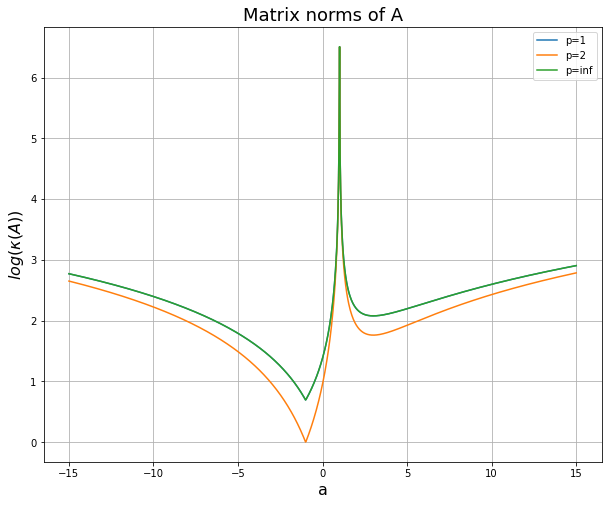

In [8]:
aa=numpy.linspace(-15,15,1000)
logK1=[numpy.log(mycond(a,1)) for a in aa]
logK2=[numpy.log(mycond(a,2)) for a in aa]
logKinf=[numpy.log(mycond(a,numpy.infty)) for a in aa]

fig = plt.figure(figsize=(10,8))
axes = fig.add_subplot(1, 1, 1)

axes.plot(aa, logK1, label='p=1')
axes.plot(aa, logK2, label='p=2')
axes.plot(aa, logKinf, label='p=inf')
#axes.plot(aa, [numpy.linalg.cond(A(a), 1) for a in aa],label='numpy')
axes.set_title("Matrix norms of A", fontsize=18)
axes.set_xlabel("a", fontsize=16)
axes.set_ylabel("$log(\kappa(A))$", fontsize=16)
axes.legend(loc='best')
axes.grid()


plt.show()

**(d)** [8] Given your plot comment on the following:
* What value of $a$ gives the best conditioned matrix.  Why?
* What value of $a$ gives the least well-condition matrix.  Why?
* Does it matter which norm we measure the condition number in?
* What value of $a$ gives the best conditioned matrix for $a>1$
 

# 

a=-1 gives the best conditioned matrix, because this makes the colunm vecters orthogonal to each other.

a=1 gives the least well-condition matrix, because that makes A singular.

It does not matter which norm we use.

When a=3, it has a local minimum.

#### **(e)** [6] The Geometry of matrix Norms

Let us explore the geometrical relationship implied by the induce matrix $p$-norm which can be viewed as a measure of how much the $A\mathbf{x}$ distorts the 'unit-ball' 

$$\{ \mathbf{x}\in\mathbb{R}^n:   \forall\, ||\mathbf{x}||_p=1\}$$

I will provide a routine to plot the unit ball and the image of $A$ acting on the unit ball here (modified from some cool routines by Kyle Mandli).  The following cell will import it and demonstrate how it's called

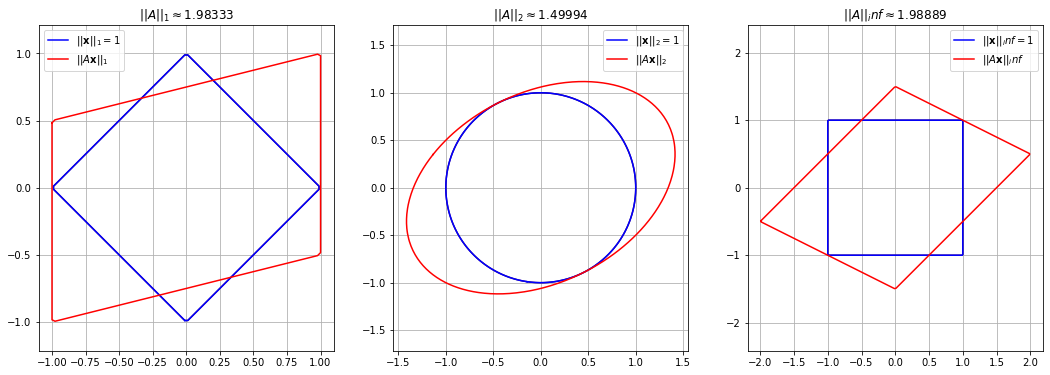

In [9]:
from unit_ball import unit_ball_image

# an Example comparing the behavior of the 1-norm, 2-norm and inf-norm
a=-0.5
fig = plt.figure(figsize=(18,6))
axes = fig.add_subplot(1,3,1, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A(a), 1)
axes = fig.add_subplot(1,3,2, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A(a), 2)
axes = fig.add_subplot(1,3,3, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A(a), numpy.inf)

plt.show()


Use this routine to make a figure comparing $||A(a)||_p$ and $||A^{-1}(a)||_p$ for $p=1,2,\infty$ and
* the best conditioned value of $a$
* a=1.08 (or as close to singular as you want to go). Can you explain why all the norms agree as $a\rightarrow1$?
* the best conditioned value of $a>1$

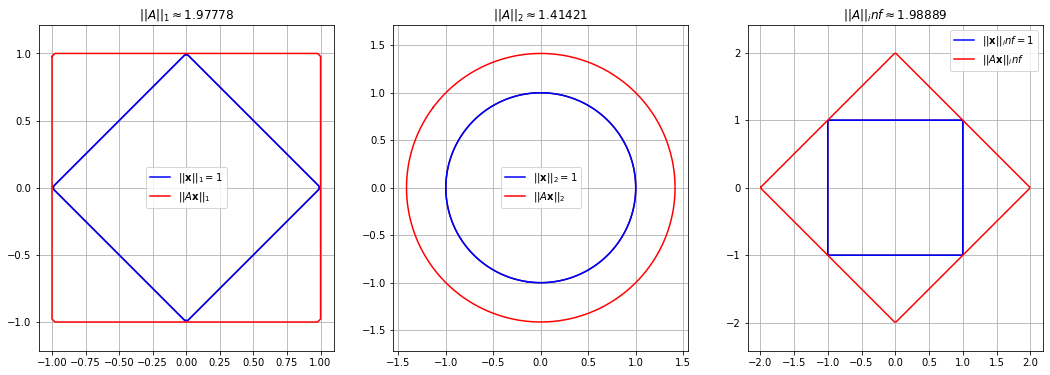

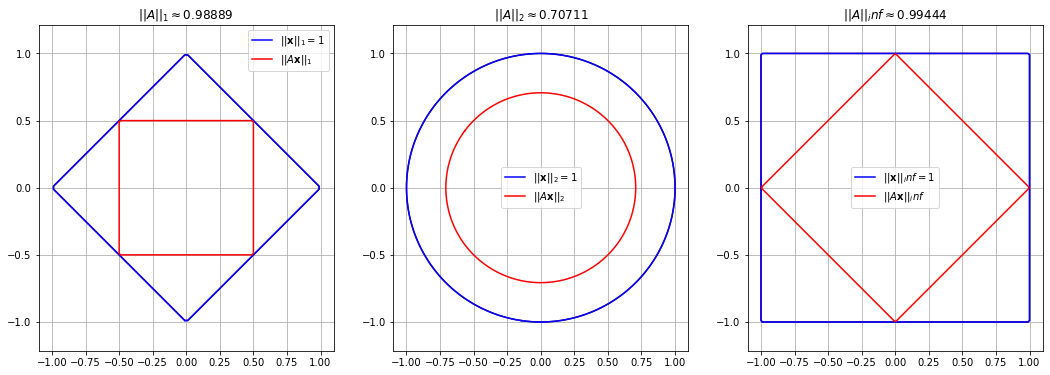

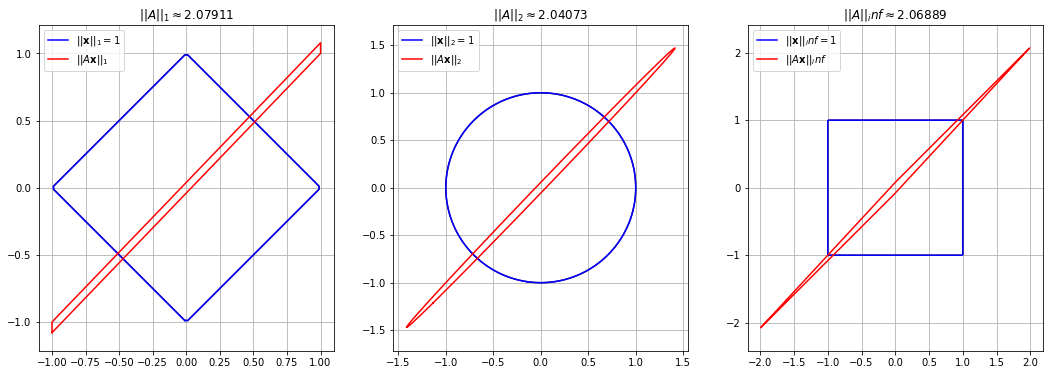

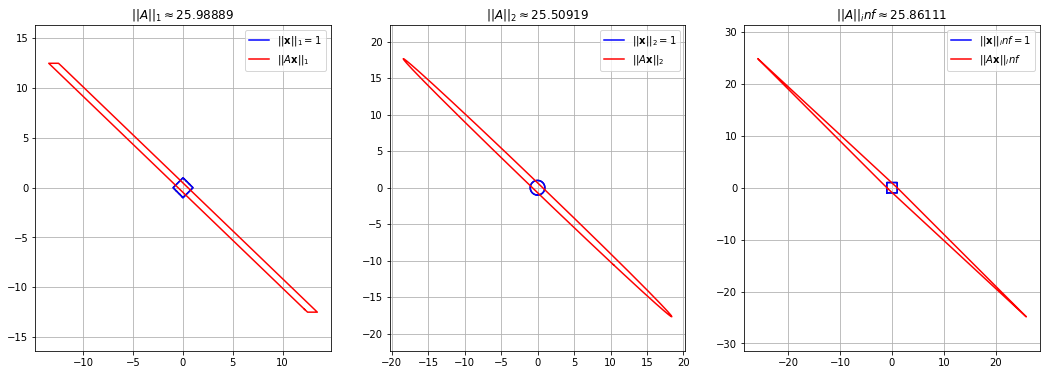

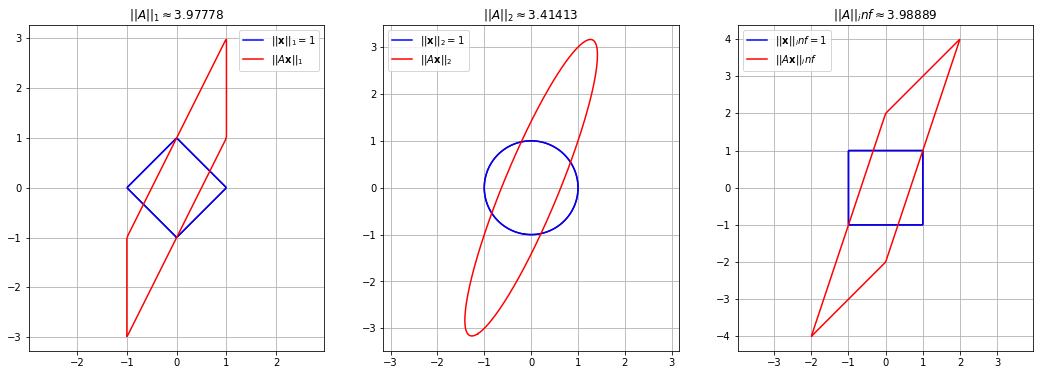

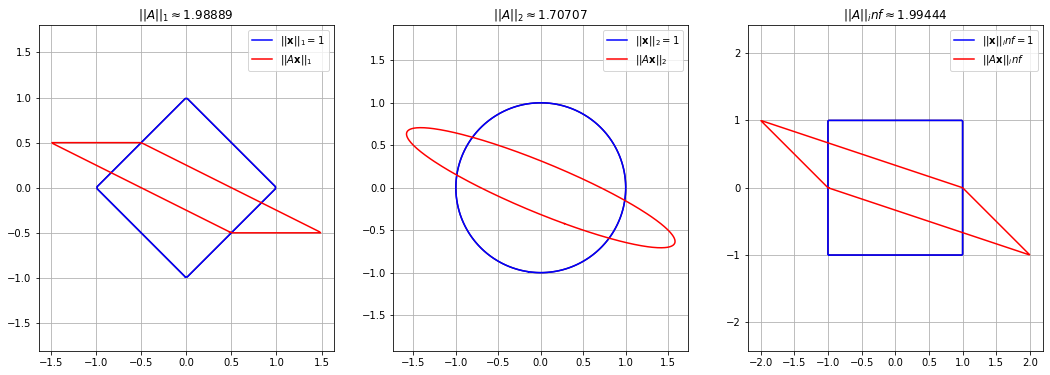

In [10]:
A_inv=lambda a: numpy.array([ [ a/(a-1), -1/(a-1)], [-1/(a-1), 1/(a-1)]])

a=-1
fig = plt.figure(figsize=(18,6))
axes = fig.add_subplot(1,3,1, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A(a), 1)
axes = fig.add_subplot(1,3,2, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A(a), 2)
axes = fig.add_subplot(1,3,3, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A(a), numpy.inf)
fig = plt.figure(figsize=(18,6))
axes = fig.add_subplot(1,3,1, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A_inv(a), 1)
axes = fig.add_subplot(1,3,2, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A_inv(a), 2)
axes = fig.add_subplot(1,3,3, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A_inv(a), numpy.inf)

plt.show()

a=1.08
fig = plt.figure(figsize=(18,6))
axes = fig.add_subplot(1,3,1, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A(a), 1)
axes = fig.add_subplot(1,3,2, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A(a), 2)
axes = fig.add_subplot(1,3,3, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A(a), numpy.inf)
fig = plt.figure(figsize=(18,6))
axes = fig.add_subplot(1,3,1, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A_inv(a), 1)
axes = fig.add_subplot(1,3,2, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A_inv(a), 2)
axes = fig.add_subplot(1,3,3, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A_inv(a), numpy.inf)

plt.show()

a=3
fig = plt.figure(figsize=(18,6))
axes = fig.add_subplot(1,3,1, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A(a), 1)
axes = fig.add_subplot(1,3,2, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A(a), 2)
axes = fig.add_subplot(1,3,3, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A(a), numpy.inf)
fig = plt.figure(figsize=(18,6))
axes = fig.add_subplot(1,3,1, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A_inv(a), 1)
axes = fig.add_subplot(1,3,2, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A_inv(a), 2)
axes = fig.add_subplot(1,3,3, aspect='equal', adjustable='datalim')
max_norm = unit_ball_image(axes, A_inv(a), numpy.inf)

plt.show()